In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Layer, Input
from tensorflow.nn import relu, tanh

In [2]:
# print package versions
print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)
print("sklearn version:", sklearn.__version__)

numpy version: 1.21.6
tensorflow version: 2.9.2
pandas version: 1.3.5
sklearn version: 1.0.2


In [3]:
# set random seed for reproducible results
SEED = 42004
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.compat.v1.set_random_seed(SEED)

In [8]:
# use if running through Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import FCNN training and validation dataset

In [9]:
# import data; if using Google Colab, folder structure will be:
# "/content/drive/My Drive/folder_name/filename.xlsx"
data = pd.read_excel('Rn_DL_data_S2.xlsx')

# define column names; water depth (depth; m), water temp (ctdtemp; deg C), 
# and ctdsal (salinity) are parameters measured at the location of the radon 
# time series using a ctd or similar sensor. _p# and _m# indicate the parameter 
# shifted (p)lus or (m)inus n time steps. Wind speed (m/s), and air temp (deg C) 
# can be obtained from a local meteorological station, Rn-222 in water (Bq/m^3) 
# is obtained using a radon-in-air detector or similar.
data.columns = ['Datetime', 'Location', 'Aquifer_type', 
                'depth_m', 'ctdtemp_C', 'ctdsal', 
                'depth_m1', 'ctdtemp_m1', 'ctdsal_m1', 
                'depth_p1', 'ctdtemp_p1', 'ctdsal_p1', 
                'depth_m2', 'ctdtemp_m2', 'ctdsal_m2', 
                'depth_p2', 'ctdtemp_p2', 'ctdsal_p2', 
                'depth_m3', 'ctdtemp_m3', 'ctdsal_m3', 
                'depth_p3', 'ctdtemp_p3', 'ctdsal_p3', 
                'depth_m4', 'ctdtemp_m4', 'ctdsal_m4', 
                'depth_p4', 'ctdtemp_p4', 'ctdsal_p4', 
                'depth_m5', 'ctdtemp_m5', 'ctdsal_m5', 
                'depth_p5', 'ctdtemp_p5', 'ctdsal_p5',  
                'depth_m6', 'ctdtemp_m6', 'ctdsal_m6', 
                'depth_p6', 'ctdtemp_p6', 'ctdsal_p6', 
                'windsp_ms', 'airtemp_C', 
                'windsp_m1', 'airtemp_m1', 
                'windsp_p1', 'airtemp_p1', 
                'windsp_m2', 'airtemp_m2', 
                'windsp_p2', 'airtemp_p2', 
                'windsp_m3', 'airtemp_m3', 
                'windsp_p3', 'airtemp_p3', 
                'windsp_m4', 'airtemp_m4', 
                'windsp_p4', 'airtemp_p4', 
                'windsp_m5', 'airtemp_m5',
                'windsp_p5', 'airtemp_p5', 
                'windsp_m6', 'airtemp_m6', 
                'windsp_p6', 'airtemp_p6', 'Rn_Bqm3'] 

# convert first column to datetime format
data.Datetime = pd.to_datetime(data.Datetime)

# drop variables that will not be used in model
data = data.drop(['Datetime', 'Location', 'Aquifer_type'], axis = 1)

# drop rows with missing values
data = data.dropna()
data.head()

,depth_m,ctdtemp_C,ctdsal,depth_m1,ctdtemp_m1,ctdsal_m1,depth_p1,ctdtemp_p1,ctdsal_p1,depth_m2,...,airtemp_p4,windsp_m5,airtemp_m5,windsp_p5,airtemp_p5,windsp_m6,airtemp_m6,windsp_p6,airtemp_p6,Rn_Bqm3
6,1.0,30.24,32.96,1.0,29.53,32.09,1.0,30.95,33.70,1.0,...,28.4,0.000000,27.6,6.111111,28.5,0.000000,27.4,5.277778,28.0,0.000000
7,1.0,29.53,32.09,1.0,29.44,32.88,1.0,30.24,32.96,1.0,...,28.2,0.000000,27.4,7.222222,28.4,0.000000,27.4,6.111111,28.5,0.000000
8,1.0,29.44,32.88,1.0,29.03,33.63,1.0,29.53,32.09,1.0,...,28.3,0.000000,27.4,6.111111,28.2,1.944444,26.3,7.222222,28.4,0.000000
9,1.0,29.03,33.63,1.0,28.57,30.30,1.0,29.44,32.88,1.0,...,28.5,1.944444,26.3,8.333333,28.3,1.666667,26.3,6.111111,28.2,78.796736
10,1.0,28.57,30.30,1.0,28.31,29.04,1.0,29.03,33.63,1.0,...,28.8,1.666667,26.3,6.111111,28.5,1.666667,26.2,8.333333,28.3,169.160931


## Pre-processing

In [10]:
# print min and max values; if var has negative min vlaue, then need to rescale
print(np.min(data))
print(np.max(data))

depth_m      -1.710000
ctdtemp_C     9.040000
ctdsal        0.123587
depth_m1     -1.710000
ctdtemp_m1    9.040000
                ...   
windsp_m6     0.000000
airtemp_m6   -6.750000
windsp_p6     0.000000
airtemp_p6   -6.750000
Rn_Bqm3       0.000000
Length: 66, dtype: float64
depth_m         16.720000
ctdtemp_C       37.100000
ctdsal          49.304814
depth_m1        16.720000
ctdtemp_m1      37.100000
                 ...     
windsp_m6       19.720000
airtemp_m6      42.000000
windsp_p6       19.720000
airtemp_p6      42.000000
Rn_Bqm3       7173.832233
Length: 66, dtype: float64


In [11]:
# rescale minimum to 0 for variables with negative values
data['depth_m'] = data['depth_m'] + abs(np.min(data['depth_m']))

data['depth_m1'] = data['depth_m1'] + abs(np.min(data['depth_m1']))
data['depth_p1'] = data['depth_p1'] + abs(np.min(data['depth_p1']))

data['depth_m2'] = data['depth_m2'] + abs(np.min(data['depth_m2']))
data['depth_p2'] = data['depth_p2'] + abs(np.min(data['depth_p2']))

data['depth_m3'] = data['depth_m3'] + abs(np.min(data['depth_m3']))
data['depth_p3'] = data['depth_p3'] + abs(np.min(data['depth_p3']))

data['depth_m4'] = data['depth_m4'] + abs(np.min(data['depth_m4']))
data['depth_p4'] = data['depth_p4'] + abs(np.min(data['depth_p4']))

data['depth_m5'] = data['depth_m5'] + abs(np.min(data['depth_m5']))
data['depth_p5'] = data['depth_p5'] + abs(np.min(data['depth_p5']))

data['depth_m6'] = data['depth_m6'] + abs(np.min(data['depth_m6']))
data['depth_p6'] = data['depth_p6'] + abs(np.min(data['depth_p6']))

data['airtemp_C'] =  data['airtemp_C'] + abs(np.min(data['airtemp_C']))
data['windsp_ms'] =  data['windsp_ms'] + abs(np.min(data['windsp_ms']))

data['airtemp_m1'] = data['airtemp_m1'] + abs(np.min(data['airtemp_m1']))
data['airtemp_p1'] = data['airtemp_p1'] + abs(np.min(data['airtemp_p1']))

data['airtemp_m2'] = data['airtemp_m2'] + abs(np.min(data['airtemp_m2']))
data['airtemp_p2'] = data['airtemp_p2'] + abs(np.min(data['airtemp_p2']))

data['airtemp_m3'] = data['airtemp_m3'] + abs(np.min(data['airtemp_m3']))
data['airtemp_p3'] = data['airtemp_p3'] + abs(np.min(data['airtemp_p3']))

data['airtemp_m4'] = data['airtemp_m4'] + abs(np.min(data['airtemp_m4']))
data['airtemp_p4'] = data['airtemp_p4'] + abs(np.min(data['airtemp_p4']))

data['airtemp_m5'] = data['airtemp_m5'] + abs(np.min(data['airtemp_m5']))
data['airtemp_p5'] = data['airtemp_p5'] + abs(np.min(data['airtemp_p5']))

data['airtemp_m6'] = data['airtemp_m6'] + abs(np.min(data['airtemp_m6']))
data['airtemp_p6'] = data['airtemp_p6'] + abs(np.min(data['airtemp_p6']))

# double check that there are no more minimum negative values
print(np.min(data))

depth_m       0.000000
ctdtemp_C     9.040000
ctdsal        0.123587
depth_m1      0.000000
ctdtemp_m1    9.040000
                ...   
windsp_m6     0.000000
airtemp_m6    0.000000
windsp_p6     0.000000
airtemp_p6    0.000000
Rn_Bqm3       0.000000
Length: 66, dtype: float64


In [12]:
# normalize data
data_norm = data

data_norm['depth_m'] = (data['depth_m'] - min(data['depth_m'])) / (max(data['depth_m']) - min(data['depth_m']))
data_norm['ctdtemp_C'] = (data['ctdtemp_C'] - min(data['ctdtemp_C'])) / (max(data['ctdtemp_C']) - min(data['ctdtemp_C']))
data_norm['ctdsal'] = (data['ctdsal'] - min(data['ctdsal']))  /(max(data['ctdsal']) - min(data['ctdsal']))
data_norm['airtemp_C'] = (data['airtemp_C'] - min(data['airtemp_C'])) / (max(data['airtemp_C']) - min(data['airtemp_C']))
data_norm['windsp_ms'] = (data['windsp_ms'] - min(data['windsp_ms'])) / (max(data['windsp_ms']) - min(data['windsp_ms']))
data_norm['Rn_Bqm3'] = (data['Rn_Bqm3'] - min(data['Rn_Bqm3'])) / (max(data['Rn_Bqm3']) - min(data['Rn_Bqm3']))

data_norm['depth_m1'] = (data['depth_m1'] - min(data['depth_m1'])) / (max(data['depth_m1']) - min(data['depth_m1']))
data_norm['ctdtemp_m1'] = (data['ctdtemp_m1'] - min(data['ctdtemp_m1'])) / (max(data['ctdtemp_m1']) - min(data['ctdtemp_m1']))
data_norm['ctdsal_m1'] = (data['ctdsal_m1'] - min(data['ctdsal_m1'])) / (max(data['ctdsal_m1']) - min(data['ctdsal_m1']))
data_norm['airtemp_m1'] = (data['airtemp_m1'] - min(data['airtemp_m1'])) / (max(data['airtemp_m1']) - min(data['airtemp_m1']))
data_norm['windsp_m1'] = (data['windsp_m1'] - min(data['windsp_m1'])) / (max(data['windsp_m1']) - min(data['windsp_m1']))

data_norm['depth_p1'] = (data['depth_p1'] - min(data['depth_p1'])) / (max(data['depth_p1']) - min(data['depth_p1']))
data_norm['ctdtemp_p1'] = (data['ctdtemp_p1'] - min(data['ctdtemp_p1'])) / (max(data['ctdtemp_p1']) - min(data['ctdtemp_p1']))
data_norm['ctdsal_p1'] = (data['ctdsal_p1'] - min(data['ctdsal_p1'])) / (max(data['ctdsal_p1']) - min(data['ctdsal_p1']))
data_norm['airtemp_p1'] = (data['airtemp_p1'] - min(data['airtemp_p1'])) / (max(data['airtemp_p1']) - min(data['airtemp_p1']))
data_norm['windsp_p1'] = (data['windsp_p1'] - min(data['windsp_p1'])) / (max(data['windsp_p1']) - min(data['windsp_p1']))

data_norm['depth_m2'] = (data['depth_m2'] - min(data['depth_m2'])) / (max(data['depth_m2']) - min(data['depth_m2']))
data_norm['ctdtemp_m2'] = (data['ctdtemp_m2'] - min(data['ctdtemp_m2'])) / (max(data['ctdtemp_m2']) - min(data['ctdtemp_m2']))
data_norm['ctdsal_m2'] = (data['ctdsal_m2'] - min(data['ctdsal_m2'])) / (max(data['ctdsal_m2']) - min(data['ctdsal_m2']))
data_norm['airtemp_m2'] = (data['airtemp_m2'] - min(data['airtemp_m2'])) / (max(data['airtemp_m2']) - min(data['airtemp_m2']))
data_norm['windsp_m2'] = (data['windsp_m2'] - min(data['windsp_m2'])) / (max(data['windsp_m2']) - min(data['windsp_m2']))

data_norm['depth_p2'] = (data['depth_p2'] - min(data['depth_p2'])) / (max(data['depth_p2']) - min(data['depth_p2']))
data_norm['ctdtemp_p2'] = (data['ctdtemp_p2'] - min(data['ctdtemp_p2'])) / (max(data['ctdtemp_p2']) - min(data['ctdtemp_p2']))
data_norm['ctdsal_p2'] = (data['ctdsal_p2'] - min(data['ctdsal_p2'])) / (max(data['ctdsal_p2']) - min(data['ctdsal_p2']))
data_norm['airtemp_p2'] = (data['airtemp_p2'] - min(data['airtemp_p2'])) / (max(data['airtemp_p2']) - min(data['airtemp_p2']))
data_norm['windsp_p2'] = (data['windsp_p2'] - min(data['windsp_p2'])) / (max(data['windsp_p2']) - min(data['windsp_p2']))

data_norm['depth_m3'] = (data['depth_m3'] - min(data['depth_m3'])) / (max(data['depth_m3']) - min(data['depth_m3']))
data_norm['ctdtemp_m3'] = (data['ctdtemp_m3'] - min(data['ctdtemp_m3'])) / (max(data['ctdtemp_m3']) - min(data['ctdtemp_m3']))
data_norm['ctdsal_m3'] = (data['ctdsal_m3'] - min(data['ctdsal_m3'])) / (max(data['ctdsal_m3']) - min(data['ctdsal_m3']))
data_norm['airtemp_m3'] = (data['airtemp_m3'] - min(data['airtemp_m3'])) / (max(data['airtemp_m3']) - min(data['airtemp_m3']))
data_norm['windsp_m3'] = (data['windsp_m3'] - min(data['windsp_m3'])) / (max(data['windsp_m3']) - min(data['windsp_m3']))

data_norm['depth_p3'] = (data['depth_p3'] - min(data['depth_p3'])) / (max(data['depth_p3']) - min(data['depth_p3']))
data_norm['ctdtemp_p3'] = (data['ctdtemp_p3'] - min(data['ctdtemp_p3'])) / (max(data['ctdtemp_p3']) - min(data['ctdtemp_p3']))
data_norm['ctdsal_p3'] = (data['ctdsal_p3'] - min(data['ctdsal_p3'])) / (max(data['ctdsal_p3']) - min(data['ctdsal_p3']))
data_norm['airtemp_p3'] = (data['airtemp_p3'] - min(data['airtemp_p3'])) / (max(data['airtemp_p3']) - min(data['airtemp_p3']))
data_norm['windsp_p3'] = (data['windsp_p3'] - min(data['windsp_p3'])) / (max(data['windsp_p3']) - min(data['windsp_p3']))

data_norm['depth_m4'] = (data['depth_m4'] - min(data['depth_m4'])) / (max(data['depth_m4']) - min(data['depth_m4']))
data_norm['ctdtemp_m4'] = (data['ctdtemp_m4'] - min(data['ctdtemp_m4'])) / (max(data['ctdtemp_m4']) - min(data['ctdtemp_m4']))
data_norm['ctdsal_m4'] = (data['ctdsal_m4'] - min(data['ctdsal_m4'])) / (max(data['ctdsal_m4']) - min(data['ctdsal_m4']))
data_norm['airtemp_m4'] = (data['airtemp_m4'] - min(data['airtemp_m4'])) / (max(data['airtemp_m4']) - min(data['airtemp_m4']))
data_norm['windsp_m4'] = (data['windsp_m4'] - min(data['windsp_m4'])) / (max(data['windsp_m4']) - min(data['windsp_m4']))

data_norm['depth_p4'] = (data['depth_p4'] - min(data['depth_p4'])) / (max(data['depth_p4']) - min(data['depth_p4']))
data_norm['ctdtemp_p4'] = (data['ctdtemp_p4'] - min(data['ctdtemp_p4'])) / (max(data['ctdtemp_p4']) - min(data['ctdtemp_p4']))
data_norm['ctdsal_p4'] = (data['ctdsal_p4'] - min(data['ctdsal_p4'])) / (max(data['ctdsal_p4']) - min(data['ctdsal_p4']))
data_norm['airtemp_p4'] = (data['airtemp_p4'] - min(data['airtemp_p4'])) / (max(data['airtemp_p4']) - min(data['airtemp_p4']))
data_norm['windsp_p4'] = (data['windsp_p4'] - min(data['windsp_p4'])) / (max(data['windsp_p4']) - min(data['windsp_p4']))

data_norm['depth_m5'] = (data['depth_m5'] - min(data['depth_m5'])) / (max(data['depth_m5']) - min(data['depth_m5']))
data_norm['ctdtemp_m5'] = (data['ctdtemp_m5'] - min(data['ctdtemp_m5'])) / (max(data['ctdtemp_m5']) - min(data['ctdtemp_m5']))
data_norm['ctdsal_m5'] = (data['ctdsal_m5'] - min(data['ctdsal_m5'])) / (max(data['ctdsal_m5']) - min(data['ctdsal_m5']))
data_norm['airtemp_m5'] = (data['airtemp_m5'] - min(data['airtemp_m5'])) / (max(data['airtemp_m5']) - min(data['airtemp_m5']))
data_norm['windsp_m5'] = (data['windsp_m5'] - min(data['windsp_m5'])) / (max(data['windsp_m5']) - min(data['windsp_m5']))

data_norm['depth_p5'] = (data['depth_p5'] - min(data['depth_p5'])) / (max(data['depth_p5']) - min(data['depth_p5']))
data_norm['ctdtemp_p5'] = (data['ctdtemp_p5'] - min(data['ctdtemp_p5'])) / (max(data['ctdtemp_p5']) - min(data['ctdtemp_p5']))
data_norm['ctdsal_p5'] = (data['ctdsal_p5'] - min(data['ctdsal_p5'])) / (max(data['ctdsal_p5']) - min(data['ctdsal_p5']))
data_norm['airtemp_p5'] = (data['airtemp_p5'] - min(data['airtemp_p5'])) / (max(data['airtemp_p5']) - min(data['airtemp_p5']))
data_norm['windsp_p5'] = (data['windsp_p5'] - min(data['windsp_p5'])) / (max(data['windsp_p5']) - min(data['windsp_p5']))

data_norm['depth_m6'] = (data['depth_m6'] - min(data['depth_m6'])) / (max(data['depth_m6']) - min(data['depth_m6']))
data_norm['ctdtemp_m6'] = (data['ctdtemp_m6'] - min(data['ctdtemp_m6'])) / (max(data['ctdtemp_m6']) - min(data['ctdtemp_m6']))
data_norm['ctdsal_m6'] = (data['ctdsal_m6'] - min(data['ctdsal_m6'])) / (max(data['ctdsal_m6']) - min(data['ctdsal_m6']))
data_norm['airtemp_m6'] = (data['airtemp_m6'] - min(data['airtemp_m6'])) / (max(data['airtemp_m6']) - min(data['airtemp_m6']))
data_norm['windsp_m6'] = (data['windsp_m6'] - min(data['windsp_m6'])) / (max(data['windsp_m6']) - min(data['windsp_m6']))

data_norm['depth_p6'] = (data['depth_p6'] - min(data['depth_p6'])) / (max(data['depth_p6']) - min(data['depth_p6']))
data_norm['ctdtemp_p6'] = (data['ctdtemp_p6'] - min(data['ctdtemp_p6'])) / (max(data['ctdtemp_p6']) - min(data['ctdtemp_p6']))
data_norm['ctdsal_p6'] = (data['ctdsal_p6'] - min(data['ctdsal_p6'])) / (max(data['ctdsal_p6']) - min(data['ctdsal_p6']))
data_norm['airtemp_p6'] = (data['airtemp_p6'] - min(data['airtemp_p6'])) / (max(data['airtemp_p6']) - min(data['airtemp_p6']))
data_norm['windsp_p6'] = (data['windsp_p6'] - min(data['windsp_p6'])) / (max(data['windsp_p6']) - min(data['windsp_p6']))

In [13]:
# train, validation (test) split (80/20 split)
train, test = train_test_split(data_norm, test_size = 0.2)

#  double check that NaNs are removed from both sets
train = train.dropna()
test = test.dropna()

In [14]:
# divide combined dataframe into X (input) and y (predictive) sets for 
# both the training and validation sets
X_train = train.drop(['Rn_Bqm3'], axis = 1)
y_train = train['Rn_Bqm3']

X_test = test.drop(['Rn_Bqm3'], axis = 1)
y_test = test['Rn_Bqm3']

# make sure dtypes for x, y are floats
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# FCNN Model

In [15]:
# define model
model = Sequential()

model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(.05))

model.add(Dense(units = 400, activation = 'relu'))
model.add(Dropout(.05))
model.add(Dense(units = 700, activation = 'relu'))

model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 300))

model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 64))

model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units = 64))

model.add(Dense(units = 900, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(units = 10, activation = 'tanh'))

model.add(Dense(1))

# reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                 factor = 0.8,
                                                 patience = 7, 
                                                 min_lr = 0.00001)

# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            patience = 10)

# compile FCNN with learning rate optimizer & early stopping; monitor MAE, RMSE
model.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 1e-07, amsgrad = False), 
              loss = 'mae', 
              metrics = ['mean_absolute_error', 'RootMeanSquaredError'])

In [16]:
# Fit the model
hist = model.fit(X_train, y_train, 
                 validation_data = (X_test, y_test), 
                 epochs = 500, 
                 batch_size = 1000, 
                 callbacks = [callback, reduce_lr], 
                 verbose = 1)

Epoch 1/500
31/31 [==============================] - 9s 226ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0613 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187 - val_root_mean_squared_error: 0.0383 - lr: 0.0010
Epoch 2/500
31/31 [==============================] - 10s 333ms/step - loss: 0.0191 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0397 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180 - val_root_mean_squared_error: 0.0382 - lr: 0.0010
Epoch 3/500
31/31 [==============================] - 7s 218ms/step - loss: 0.0187 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0393 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173 - val_root_mean_squared_error: 0.0362 - lr: 0.0010
Epoch 4/500
31/31 [==============================] - 7s 218ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0382 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173 - val_root_mean_squared_error: 0.0370 - lr: 0.0010

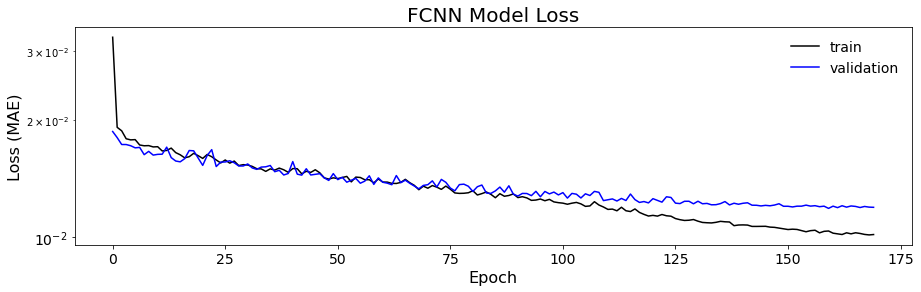

In [17]:
# plot model convergence
plt.figure(figsize = (15,4))
plt.tick_params(labelsize = 14)

plt.semilogy(hist.history['loss'], color = 'black')
plt.semilogy(hist.history['val_loss'], color = 'blue')

plt.tick_params(labelsize = 14)
plt.title('FCNN Model Loss', fontsize = 20)
plt.ylabel('Loss (MAE)', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['train', 'validation'], 
           loc='upper right', 
           frameon = False, 
           fontsize = 14)

plt.show()

## Model prediction (training & validation set)

In [18]:
# Rn prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# concat training and validation
y_pred = np.concatenate((y_train_pred, y_test_pred), axis = 0)

# evaluate model
test_loss_a = model.evaluate(X_train, y_train)
test_loss_b = model.evaluate(X_test, y_test)

# print loss results for train and validation sets
print(test_loss_a)
print(test_loss_b)

241/241 [==============================] - 2s 6ms/step - loss: 0.0119 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0219
[0.008914479054510593, 0.008914479054510593, 0.016845982521772385]
[0.011918283998966217, 0.011918283998966217, 0.021874206140637398]


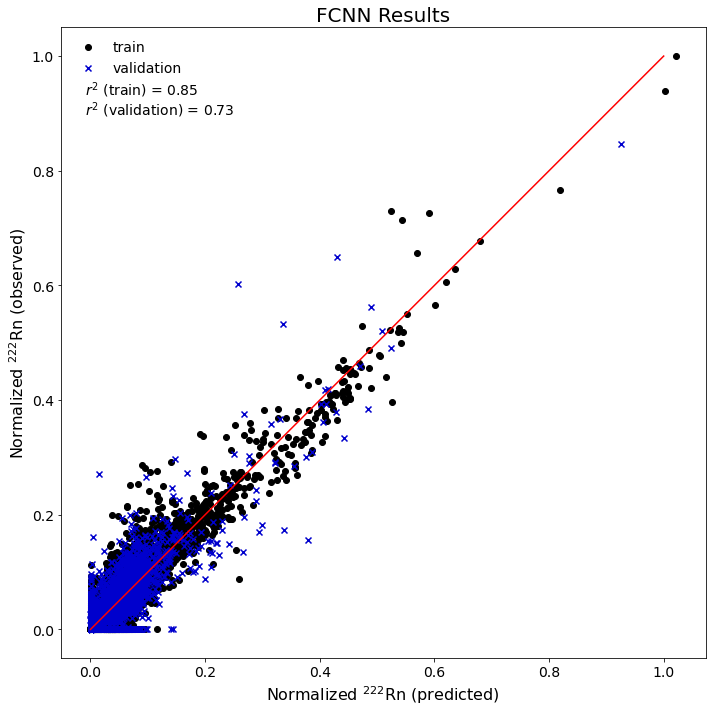

In [19]:
# calculate r^2 between predicted and observed Rn
R2_train = r2_score(y_train, y_train_pred, multioutput = 'variance_weighted')
R2_test = r2_score(y_test, y_test_pred, multioutput = 'variance_weighted')

# plot y vs y pred 45 degree mismatch (with train/validation split)
plt.figure(figsize = (10,10))
plt.scatter(y_train_pred, y_train, alpha = 1, label = 'train', color = 'black')
plt.scatter(y_test_pred, y_test, alpha = 1, label = 'validation', marker ='x', 
            color = 'mediumblue')

plt.legend(frameon = False, fontsize = 14)
plt.xlabel('Normalized $^{222}$Rn (predicted)', fontsize = 16)
plt.ylabel('Normalized $^{222}$Rn (observed)', fontsize = 16)
plt.title('FCNN Results', fontsize = 20)
 
# plot 45 degree line
x1 = np.linspace(0, 1, 1000)
plt.plot(x1,x1, c = "red") 

# plot r^2 results on figure
plt.text(-0.01, 0.933, '$r^2$ (train) = %0.2f' % R2_train, fontsize = 14)
plt.text(-0.01, 0.898, '$r^2$ (validation) = %0.2f' % R2_test, fontsize = 14)

plt.tick_params(labelsize = 14)
plt.tight_layout()
plt.show()

# Prediction of new data using trained model

## Pre-processing

In [ ]:
# import new data
# import dataset, replace "filename.xlsx" with the name of the file
data_A = pd.read_excel('filename.xlsx')

# define column names; ocean water level (owl; m), ctdtemp (deg C), and ctdsal
# are parameters measured at the location of the radon time series using a ctd
# or similar sensor. owl/ctdtemp/ctdsal _m1, _p1, etc. are these same parameters 
# moved (m)inus (p)lus 1 hour, up to +/- 6 hours. Wind speed (m/s), and
# air temperature (deg C) can be obtained from a local meteorological station, 
# Rn-222 in water (Bq/m^3) is obtained using a radon-in-air detector or similar.
data_A.columns = ['Datetime', 'Location', 'Aquifer_type', 
                'depth_m', 'ctdtemp_C', 'ctdsal', 
                'depth_m1', 'ctdtemp_m1', 'ctdsal_m1', 
                'depth_p1', 'ctdtemp_p1', 'ctdsal_p1', 
                'depth_m2', 'ctdtemp_m2', 'ctdsal_m2', 
                'depth_p2', 'ctdtemp_p2', 'ctdsal_p2', 
                'depth_m3', 'ctdtemp_m3', 'ctdsal_m3', 
                'depth_p3', 'ctdtemp_p3', 'ctdsal_p3', 
                'depth_m4', 'ctdtemp_m4', 'ctdsal_m4', 
                'depth_p4', 'ctdtemp_p4', 'ctdsal_p4', 
                'depth_m5', 'ctdtemp_m5', 'ctdsal_m5', 
                'depth_p5', 'ctdtemp_p5', 'ctdsal_p5',  
                'depth_m6', 'ctdtemp_m6', 'ctdsal_m6', 
                'depth_p6', 'ctdtemp_p6', 'ctdsal_p6', 
                'windsp_ms', 'airtemp_C', 
                'windsp_m1', 'airtemp_m1', 
                'windsp_p1', 'airtemp_p1', 
                'windsp_m2', 'airtemp_m2', 
                'windsp_p2', 'airtemp_p2', 
                'windsp_m3', 'airtemp_m3', 
                'windsp_p3', 'airtemp_p3', 
                'windsp_m4', 'airtemp_m4', 
                'windsp_p4', 'airtemp_p4', 
                'windsp_m5', 'airtemp_m5',
                'windsp_p5', 'airtemp_p5', 
                'windsp_m6', 'airtemp_m6', 
                'windsp_p6', 'airtemp_p6', 'Rn_Bqm3'] 

# convert first column to datetime format
data_A.datetime = pd.to_datetime(data_A.Datetime)

# drop variables that will not be used in model
data_A = data_A.drop(['Datetime', 'Location', 'Aquifer_type'], axis = 1)

# drop rows with missing values
data_A = data_A.dropna()
data_A.head()

In [ ]:
# print min and max values; if var has negative min vlaue, then need to rescale
# note: min and max values must be within the range in the model was trained
# with
print(np.min(data_A))
print(np.max(data_A))

In [ ]:
# rescale minimum to 0 for variables with negative values
data_A['depth_m'] = data_A['depth_m'] + abs(np.min(data_A['depth_m']))

data_A['depth_m1'] = data_A['depth_m1'] + abs(np.min(data_A['depth_m1']))
data_A['depth_p1'] = data_A['depth_p1'] + abs(np.min(data_A['depth_p1']))

data_A['depth_m2'] = data_A['depth_m2'] + abs(np.min(data_A['depth_m2']))
data_A['depth_p2'] = data_A['depth_p2'] + abs(np.min(data_A['depth_p2']))

data_A['depth_m3'] = data_A['depth_m3'] + abs(np.min(data_A['depth_m3']))
data_A['depth_p3'] = data_A['depth_p3'] + abs(np.min(data_A['depth_p3']))

data_A['depth_m4'] = data_A['depth_m4'] + abs(np.min(data_A['depth_m4']))
data_A['depth_p4'] = data_A['depth_p4'] + abs(np.min(data_A['depth_p4']))

data_A['depth_m5'] = data_A['depth_m5'] + abs(np.min(data_A['depth_m5']))
data_A['depth_p5'] = data_A['depth_p5'] + abs(np.min(data_A['depth_p5']))

data_A['depth_m6'] = data_A['depth_m6'] + abs(np.min(data_A['depth_m6']))
data_A['depth_p6'] = data_A['depth_p6'] + abs(np.min(data_A['depth_p6']))

data_A['airtemp_C'] =  data_A['airtemp_C'] + abs(np.min(data_A['airtemp_C']))
data_A['windsp_ms'] =  data_A['windsp_ms'] + abs(np.min(data_A['windsp_ms']))

data_A['airtemp_m1'] = data_A['airtemp_m1'] + abs(np.min(data_A['airtemp_m1']))
data_A['airtemp_p1'] = data_A['airtemp_p1'] + abs(np.min(data_A['airtemp_p1']))

data_A['airtemp_m2'] = data_A['airtemp_m2'] + abs(np.min(data_A['airtemp_m2']))
data_A['airtemp_p2'] = data_A['airtemp_p2'] + abs(np.min(data_A['airtemp_p2']))

data_A['airtemp_m3'] = data_A['airtemp_m3'] + abs(np.min(data_A['airtemp_m3']))
data_A['airtemp_p3'] = data_A['airtemp_p3'] + abs(np.min(data_A['airtemp_p3']))

data_A['airtemp_m4'] = data_A['airtemp_m4'] + abs(np.min(data_A['airtemp_m4']))
data_A['airtemp_p4'] = data_A['airtemp_p4'] + abs(np.min(data_A['airtemp_p4']))

data_A['airtemp_m5'] = data_A['airtemp_m5'] + abs(np.min(data_A['airtemp_m5']))
data_A['airtemp_p5'] = data_A['airtemp_p5'] + abs(np.min(data_A['airtemp_p5']))

data_A['airtemp_m6'] = data_A['airtemp_m6'] + abs(np.min(data_A['airtemp_m6']))
data_A['airtemp_p6'] = data_A['airtemp_p6'] + abs(np.min(data_A['airtemp_p6']))

# double check that there are no more minimum negative values
print(np.min(data_A))

In [ ]:
# normalize data
data_A_norm = data_A

data_A_norm['depth_m'] = (data_A['depth_m'] - min(data_A['depth_m'])) / (max(data_A['depth_m']) - min(data_A['depth_m']))
data_A_norm['ctdtemp_C'] = (data_A['ctdtemp_C'] - min(data_A['ctdtemp_C'])) / (max(data_A['ctdtemp_C']) - min(data_A['ctdtemp_C']))
data_A_norm['ctdsal'] = (data_A['ctdsal'] - min(data_A['ctdsal'])) / (max(data_A['ctdsal']) - min(data_A['ctdsal']))
data_A_norm['airtemp_C'] = (data_A['airtemp_C'] - min(data_A['airtemp_C'])) / (max(data_A['airtemp_C']) - min(data_A['airtemp_C']))
data_A_norm['windsp_ms'] = (data_A['windsp_ms'] - min(data_A['windsp_ms'])) / (max(data_A['windsp_ms']) - min(data_A['windsp_ms']))
data_A_norm['Rn_Bqm3'] = (data_A['Rn_Bqm3'] - min(data_A['Rn_Bqm3'])) / (max(data_A['Rn_Bqm3']) - min(data_A['Rn_Bqm3']))

data_A_norm['depth_m1'] = (data_A['depth_m1'] - min(data_A['depth_m1'])) / (max(data_A['depth_m1']) - min(data_A['depth_m1']))
data_A_norm['ctdtemp_m1'] = (data_A['ctdtemp_m1'] - min(data_A['ctdtemp_m1'])) / (max(data_A['ctdtemp_m1']) - min(data_A['ctdtemp_m1']))
data_A_norm['ctdsal_m1'] = (data_A['ctdsal_m1'] - min(data_A['ctdsal_m1'])) / (max(data_A['ctdsal_m1']) - min(data_A['ctdsal_m1']))
data_A_norm['airtemp_m1'] = (data_A['airtemp_m1'] - min(data_A['airtemp_m1'])) / (max(data_A['airtemp_m1']) - min(data_A['airtemp_m1']))
data_A_norm['windsp_m1'] = (data_A['windsp_m1'] - min(data_A['windsp_m1'])) / (max(data_A['windsp_m1']) - min(data_A['windsp_m1']))

data_A_norm['depth_p1'] = (data_A['depth_p1'] - min(data_A['depth_p1'])) / (max(data_A['depth_p1']) - min(data_A['depth_p1']))
data_A_norm['ctdtemp_p1'] = (data_A['ctdtemp_p1'] - min(data_A['ctdtemp_p1'])) / (max(data_A['ctdtemp_p1']) - min(data_A['ctdtemp_p1']))
data_A_norm['ctdsal_p1'] = (data_A['ctdsal_p1'] - min(data_A['ctdsal_p1'])) / (max(data_A['ctdsal_p1']) - min(data_A['ctdsal_p1']))
data_A_norm['airtemp_p1'] = (data_A['airtemp_p1'] - min(data_A['airtemp_p1'])) / (max(data_A['airtemp_p1']) - min(data_A['airtemp_p1']))
data_A_norm['windsp_p1'] = (data_A['windsp_p1'] - min(data_A['windsp_p1'])) / (max(data_A['windsp_p1']) - min(data_A['windsp_p1']))

data_A_norm['depth_m2'] = (data_A['depth_m2'] - min(data_A['depth_m2'])) / (max(data_A['depth_m2']) - min(data_A['depth_m2']))
data_A_norm['ctdtemp_m2'] = (data_A['ctdtemp_m2'] - min(data_A['ctdtemp_m2'])) / (max(data_A['ctdtemp_m2']) - min(data_A['ctdtemp_m2']))
data_A_norm['ctdsal_m2'] = (data_A['ctdsal_m2'] - min(data_A['ctdsal_m2'])) / (max(data_A['ctdsal_m2']) - min(data_A['ctdsal_m2']))
data_A_norm['airtemp_m2'] = (data_A['airtemp_m2'] - min(data_A['airtemp_m2'])) / (max(data_A['airtemp_m2']) - min(data_A['airtemp_m2']))
data_A_norm['windsp_m2'] = (data_A['windsp_m2'] - min(data_A['windsp_m2'])) / (max(data_A['windsp_m2']) - min(data_A['windsp_m2']))

data_A_norm['depth_p2'] = (data_A['depth_p2'] - min(data_A['depth_p2'])) / (max(data_A['depth_p2']) - min(data_A['depth_p2']))
data_A_norm['ctdtemp_p2'] = (data_A['ctdtemp_p2'] - min(data_A['ctdtemp_p2'])) / (max(data_A['ctdtemp_p2']) - min(data_A['ctdtemp_p2']))
data_A_norm['ctdsal_p2'] = (data_A['ctdsal_p2'] - min(data_A['ctdsal_p2'])) / (max(data_A['ctdsal_p2']) - min(data_A['ctdsal_p2']))
data_A_norm['airtemp_p2'] = (data_A['airtemp_p2'] - min(data_A['airtemp_p2'])) / (max(data_A['airtemp_p2']) - min(data_A['airtemp_p2']))
data_A_norm['windsp_p2'] = (data_A['windsp_p2'] - min(data_A['windsp_p2'])) / (max(data_A['windsp_p2']) - min(data_A['windsp_p2']))

data_A_norm['depth_m3'] = (data_A['depth_m3'] - min(data_A['depth_m3'])) / (max(data_A['depth_m3']) - min(data_A['depth_m3']))
data_A_norm['ctdtemp_m3'] = (data_A['ctdtemp_m3'] - min(data_A['ctdtemp_m3'])) / (max(data_A['ctdtemp_m3']) - min(data_A['ctdtemp_m3']))
data_A_norm['ctdsal_m3'] = (data_A['ctdsal_m3'] - min(data_A['ctdsal_m3'])) / (max(data_A['ctdsal_m3']) - min(data_A['ctdsal_m3']))
data_A_norm['airtemp_m3'] = (data_A['airtemp_m3'] - min(data_A['airtemp_m3'])) / (max(data_A['airtemp_m3']) - min(data_A['airtemp_m3']))
data_A_norm['windsp_m3'] = (data_A['windsp_m3'] - min(data_A['windsp_m3'])) / (max(data_A['windsp_m3']) - min(data_A['windsp_m3']))

data_A_norm['depth_p3'] = (data_A['depth_p3'] - min(data_A['depth_p3'])) / (max(data_A['depth_p3']) - min(data_A['depth_p3']))
data_A_norm['ctdtemp_p3'] = (data_A['ctdtemp_p3'] - min(data_A['ctdtemp_p3'])) / (max(data_A['ctdtemp_p3']) - min(data_A['ctdtemp_p3']))
data_A_norm['ctdsal_p3'] = (data_A['ctdsal_p3'] - min(data_A['ctdsal_p3'])) / (max(data_A['ctdsal_p3']) - min(data_A['ctdsal_p3']))
data_A_norm['airtemp_p3'] = (data_A['airtemp_p3'] - min(data_A['airtemp_p3'])) / (max(data_A['airtemp_p3']) - min(data_A['airtemp_p3']))
data_A_norm['windsp_p3'] = (data_A['windsp_p3'] - min(data_A['windsp_p3'])) / (max(data_A['windsp_p3']) - min(data_A['windsp_p3']))

data_A_norm['depth_m4'] = (data_A['depth_m4'] - min(data_A['depth_m4'])) / (max(data_A['depth_m4']) - min(data_A['depth_m4']))
data_A_norm['ctdtemp_m4'] = (data_A['ctdtemp_m4'] - min(data_A['ctdtemp_m4'])) / (max(data_A['ctdtemp_m4']) - min(data_A['ctdtemp_m4']))
data_A_norm['ctdsal_m4'] = (data_A['ctdsal_m4'] - min(data_A['ctdsal_m4'])) / (max(data_A['ctdsal_m4']) - min(data_A['ctdsal_m4']))
data_A_norm['airtemp_m4'] = (data_A['airtemp_m4'] - min(data_A['airtemp_m4'])) / (max(data_A['airtemp_m4']) - min(data_A['airtemp_m4']))
data_A_norm['windsp_m4'] = (data_A['windsp_m4'] - min(data_A['windsp_m4'])) / (max(data_A['windsp_m4']) - min(data_A['windsp_m4']))

data_A_norm['depth_p4'] = (data_A['depth_p4'] - min(data_A['depth_p4'])) / (max(data_A['depth_p4']) - min(data_A['depth_p4']))
data_A_norm['ctdtemp_p4'] = (data_A['ctdtemp_p4'] - min(data_A['ctdtemp_p4']) / (max(data_A['ctdtemp_p4']) - min(data_A['ctdtemp_p4']))
data_A_norm['ctdsal_p4'] = (data_A['ctdsal_p4'] - min(data_A['ctdsal_p4'])) / (max(data_A['ctdsal_p4']) - min(data_A['ctdsal_p4']))
data_A_norm['airtemp_p4'] = (data_A['airtemp_p4'] - min(data_A['airtemp_p4'])) / (max(data_A['airtemp_p4']) - min(data_A['airtemp_p4']))
data_A_norm['windsp_p4'] = (data_A['windsp_p4'] - min(data_A['windsp_p4'])) / (max(data_A['windsp_p4']) - min(data_A['windsp_p4']))

data_A_norm['depth_m5'] = (data_A['depth_m5'] - min(data_A['depth_m5'])) / (max(data_A['depth_m5']) - min(data_A['depth_m5']))
data_A_norm['ctdtemp_m5'] = (data_A['ctdtemp_m5'] - min(data_A['ctdtemp_m5'])) / (max(data_A['ctdtemp_m5']) - min(data_A['ctdtemp_m5']))
data_A_norm['ctdsal_m5'] = (data_A['ctdsal_m5'] - min(data_A['ctdsal_m5'])) / (max(data_A['ctdsal_m5']) - min(data_A['ctdsal_m5']))
data_A_norm['airtemp_m5'] = (data_A['airtemp_m5'] - min(data_A['airtemp_m5'])) / (max(data_A['airtemp_m5']) - min(data_A['airtemp_m5']))
data_A_norm['windsp_m5'] = (data_A['windsp_m5'] - min(data_A['windsp_m5'])) / (max(data_A['windsp_m5']) - min(data_A['windsp_m5']))

data_A_norm['depth_p5'] = (data_A['depth_p5'] - min(data_A['depth_p5'])) / (max(data_A['depth_p5']) - min(data_A['depth_p5']))
data_A_norm['ctdtemp_p5'] = (data_A['ctdtemp_p5'] - min(data_A['ctdtemp_p5'])) / (max(data_A['ctdtemp_p5']) - min(data_A['ctdtemp_p5']))
data_A_norm['ctdsal_p5'] = (data_A['ctdsal_p5'] - min(data_A['ctdsal_p5'])) / (max(data_A['ctdsal_p5']) - min(data_A['ctdsal_p5']))
data_A_norm['airtemp_p5'] = (data_A['airtemp_p5'] - min(data_A['airtemp_p5'])) / (max(data_A['airtemp_p5']) - min(data_A['airtemp_p5']))
data_A_norm['windsp_p5'] = (data_A['windsp_p5'] - min(data_A['windsp_p5'])) / (max(data_A['windsp_p5']) - min(data_A['windsp_p5']))

data_A_norm['depth_m6'] = (data_A['depth_m6'] - min(data_A['depth_m6'])) / (max(data_A['depth_m6']) - min(data_A['depth_m6']))
data_A_norm['ctdtemp_m6'] = (data_A['ctdtemp_m6'] - min(data_A['ctdtemp_m6'])) / (max(data_A['ctdtemp_m6']) - min(data_A['ctdtemp_m6']))
data_A_norm['ctdsal_m6'] = (data_A['ctdsal_m6'] - min(data_A['ctdsal_m6'])) / (max(data_A['ctdsal_m6']) - min(data_A['ctdsal_m6']))
data_A_norm['airtemp_m6'] = (data_A['airtemp_m6'] - min(data_A['airtemp_m6'])) / (max(data_A['airtemp_m6']) - min(data_A['airtemp_m6']))
data_A_norm['windsp_m6'] = (data_A['windsp_m6'] - min(data_A['windsp_m6'])) / (max(data_A['windsp_m6']) - min(data_A['windsp_m6']))

data_A_norm['depth_p6'] = (data_A['depth_p6'] - min(data_A['depth_p6'])) / (max(data_A['depth_p6']) - min(data_A['depth_p6']))
data_A_norm['ctdtemp_p6'] = (data_A['ctdtemp_p6'] - min(data_A['ctdtemp_p6'])) / (max(data_A['ctdtemp_p6']) - min(data_A['ctdtemp_p6']))
data_A_norm['ctdsal_p6'] = (data_A['ctdsal_p6'] - min(data_A['ctdsal_p6'])) / (max(data_A['ctdsal_p6']) - min(data_A['ctdsal_p6']))
data_A_norm['airtemp_p6'] = (data_A['airtemp_p6'] - min(data_A['airtemp_p6'])) / (max(data_A['airtemp_p6']) - min(data_A['airtemp_p6']))
data_A_norm['windsp_p6'] = (data_A['windsp_p6'] - min(data_A['windsp_p6'])) / (max(data_A['windsp_p6']) - min(data_A['windsp_p6']))

In [ ]:
# split X (input variables) and y (predictive variable)
X_A = data_A_norm.drop(['Rn_Bqm3'], axis = 1)
y_A = data_A_norm['Rn_Bqm3']

## Model prediction

In [ ]:
# evaluate newly imported dataset using pretrained model
y_test_A = model.predict(X_A)
test_loss_A = model.evaluate(X_A, y_A)
print(test_loss_A)

In [ ]:
# y vs y pred 45 degree mismatch for new data
plt.figure(figsize = (10,10))

plt.scatter(y_test_A, y_A, alpha = 1, label = 'new data', color = 'yellowgreen')
plt.scatter(y_train_pred, y_train, alpha = 1, label = 'train', color = 'black')
plt.scatter(y_test_pred, y_test, alpha = 1, label = 'validation', marker ='x', 
            color = 'mediumblue')

plt.legend(frameon = False, fontsize = 14)
plt.xlabel('Normalized $^{222}$Rn (predicted)', fontsize = 16)
plt.ylabel('Normalized $^{222}$Rn (observed)', fontsize = 16)
plt.title('FCNN Results', fontsize = 20)
 
# plot 45 degree line
x1 = np.linspace(0, 1, 1000)
plt.plot(x1,x1, c = "red") 

# r^2
R2_A = r2_score(y_A, y_test_A, multioutput = 'variance_weighted')
print(R2_A)
plt.text(0.001, 0.98, '$r^2$ = %0.2f' % R2_A, fontsize = 14)

plt.tick_params(labelsize = 14)
plt.tight_layout()

plt.show()